In [1]:
import numpy as np
import os
import cv2
import pickle
import random
import dlib

from collect_images import save_img
from utils import load_face_landmark_model, load_fr_model

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\windo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
face_landmarks_model = load_face_landmark_model()
fr_model = load_fr_model()

dataset_path = os.getcwd() + "\\data"

In [3]:
# name = "Prateek"
# save_img(name, dataset_path)

In [4]:
label_dictionary = {}

train_path = dataset_path + "\\train"
test_path = dataset_path + "\\test"

for i, name in enumerate(os.listdir(train_path)):
    label_dictionary[name] = i
    
inv_label_dictionary = {v: k for k, v in label_dictionary.items()}

print(label_dictionary)
print(inv_label_dictionary)

f = open("database/inv_embeddings_label_dict", "wb")
f.write(pickle.dumps(inv_label_dictionary))
f.close()

{'Pakhi': 0, 'Prateek': 1}
{0: 'Pakhi', 1: 'Prateek'}


In [5]:
train_images = []
train_labels = []

for name in os.listdir(train_path):
    curr_label = label_dictionary[name]
    for image in os.listdir(train_path + "\\" + name):
        img = cv2.imread(train_path + "\\" + name + "\\" + image)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        l, b = img.shape[0], img.shape[1]
        
        if l < 128 and b < 128:
            img = cv2.resize(img, (128, 128),  cv2.INTER_LINEAR)
        else:
            img = cv2.resize(img, (128, 128),  cv2.INTER_CUBIC)
        img = img.reshape(128, 128, 3)
        
        train_images.append(img)
        train_labels.append(curr_label)
        
zipped = list(zip(train_images, train_labels))
random.shuffle(zipped)
train_images, train_labels = zip(*zipped)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images.shape, train_labels.shape

((909, 128, 128, 3), (909,))

In [6]:
test_images = []
test_labels = []

for name in os.listdir(test_path):
    curr_label = label_dictionary[name]
    for image in os.listdir(test_path + "\\" + name):
        img = cv2.imread(test_path + "\\" + name + "\\" + image)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, (128, 128),  cv2.INTER_AREA)
        img = img.reshape(128, 128, 3)
        
        
        test_images.append(img)
        test_labels.append(curr_label)
        
zipped = list(zip(test_images, test_labels))
random.shuffle(zipped)
test_images, test_labels = zip(*zipped)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_images.shape, test_labels.shape

((50, 128, 128, 3), (50,))

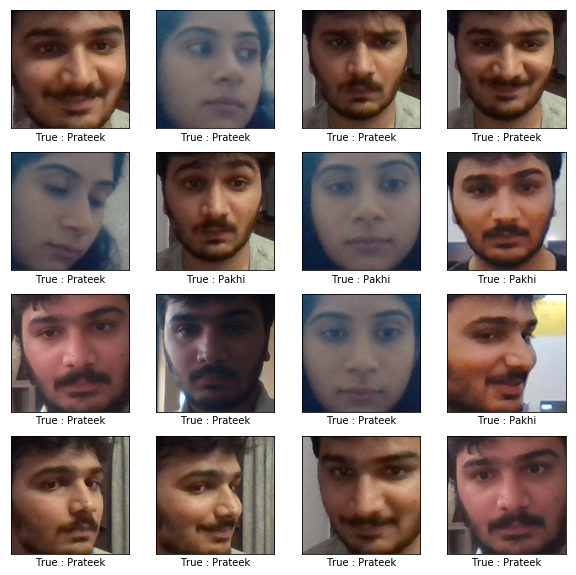

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i+19], interpolation='spline16')
    ax.set_xticks([])
    ax.set_yticks([])
    
    msg = 'True : {}'.format(inv_label_dictionary[train_labels[i]])
    ax.set_xlabel(msg)

In [8]:
def calculate_embedding(img):
    dlib_box = dlib.rectangle(0, 0, img.shape[1], img.shape[0])
    pose = face_landmarks_model(img, dlib_box)
    embedding = np.array(fr_model.compute_face_descriptor(img, pose, 1))
    return embedding

In [9]:
train_embeddings = []
for i in range(len(train_images)):
    train_embeddings.append(calculate_embedding(train_images[i]))
    if (i) % 50 == 0:
        print(str(i) + "/" + str(len(train_images)) + " done")
        
print("\n\nTotal Train Embeddings = ", end='')
print(len(train_embeddings))

data = {"encodings": train_embeddings, "labels": train_labels}
f = open("database/saved_encodings", "wb")
f.write(pickle.dumps(data))
f.close()

0/909 done
50/909 done
100/909 done
150/909 done
200/909 done
250/909 done
300/909 done
350/909 done
400/909 done
450/909 done
500/909 done
550/909 done
600/909 done
650/909 done
700/909 done
750/909 done
800/909 done
850/909 done
900/909 done


Total Train Embeddings = 909


In [10]:
test_embeddings = []
for i in range(len(test_images)):
    test_embeddings.append(calculate_embedding(test_images[i]))
    if (i) % 50 == 0:
        print(str(i) + "/" + str(len(test_images)) + " done")
        
print("\n\nTotal Test Embeddings = ", end='')
print(len(test_embeddings))

0/50 done


Total Test Embeddings = 50


In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(train_embeddings, train_labels, test_size=0.25)
print(len(xtrain), len(xtest))

681 228


In [13]:
svc = SVC(kernel='linear', probability=True)
svc.fit(xtrain, ytrain)
print("Train Score: ", svc.score(xtrain, ytrain))
print("Validation Score: ", svc.score(xtest, ytest))
print("Test Score: ", svc.score(test_embeddings, test_labels))

f = open("saved_models/svm_embeddings_model", "wb")
f.write(pickle.dumps(svc))
f.close()

Train Score:  1.0
Validation Score:  1.0
Test Score:  1.0


In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xtrain, ytrain)
print("Train Score: ", knn.score(xtrain, ytrain))
print("Validation Score: ", knn.score(xtest, ytest))
print("Test Score: ", knn.score(test_embeddings, test_labels))

f = open("saved_models/knn_embeddings_model", "wb")
f.write(pickle.dumps(knn))
f.close()

Train Score:  1.0
Validation Score:  1.0
Test Score:  1.0


In [15]:
# clf = pickle.load(open('svm_final_two_person', 'rb'))